<a href="https://colab.research.google.com/github/NabeelEhsan/BOVW/blob/model1/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



In [3]:
%cd /content/drive/MyDrive


/content/drive/MyDrive


In [ ]:
!unzip Objects_Dataset_Images-20230304T095048Z-001.zip


unzip:  cannot find or open Objects_Dataset_Images-20230304T095048Z-001.zip, Objects_Dataset_Images-20230304T095048Z-001.zip.zip or Objects_Dataset_Images-20230304T095048Z-001.zip.ZIP.


In [4]:

def load_image_data(path):
    data = []
    labels = []

    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            img = cv2.imread(os.path.join(path, folder, file))
            img = cv2.resize(img, (224, 224))
            data.append(img)
            labels.append(folder)

    return np.array(data), np.array(labels)



In [5]:
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    descriptors = []
    img_descriptors = []

    for i in images:
        keypoints, descriptor = sift.detectAndCompute(i, None)
        descriptors.extend(descriptor)
        img_descriptors.append(descriptor)
        
    return np.array(descriptors), img_descriptors

In [6]:
# Load the training and test datasets
path_to_train_dataset = "/content/drive/MyDrive/Objects_Dataset_Images/train"
path_to_test_dataset = "/content/drive/MyDrive/Objects_Dataset_Images/test"

train_data, train_labels = load_image_data(path_to_train_dataset)
test_data, test_labels = load_image_data(path_to_test_dataset)

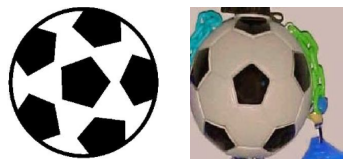

Training label: ['Soccer_Ball' 'Soccer_Ball']


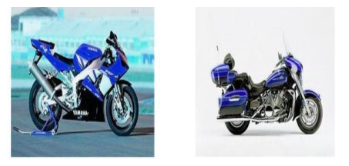

Test label: ['motorbike' 'motorbike']


In [7]:
# Display some sample images
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(train_data[i])
    plt.axis('off')
plt.show()
print('Training label: %s' % (train_labels[0:2],))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(test_data[i])
    plt.axis('off')
plt.show()
print('Test label: %s' % (test_labels[0:2],))

In [8]:
# Extract SIFT features from training and test images
d, img_d = extract_sift_features(train_data)
t, img_t = extract_sift_features(test_data)


In [9]:
# Cluster the feature descriptors
kmeans = KMeans(n_clusters=50)
kmeans.fit(d)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=50)

In [10]:
kmeans.cluster_centers_.shape

(50, 128)

In [11]:
# Fit 1-NN model to the feature descriptors
nn = NearestNeighbors(n_neighbors=1)
nn.fit(kmeans.cluster_centers_)

NearestNeighbors(n_neighbors=1)

In [12]:
# Compute histograms for training images
histograms = []
for descriptors in img_d:
    # Predict visual words using 1-NN
    distances, indices = nn.kneighbors(descriptors)
    visual_words = indices.flatten()
    # Compute histogram
    histogram, _ = np.histogram(visual_words, bins=kmeans.n_clusters)
    histograms.append(histogram)

# Normalize histograms
scaler = StandardScaler()
histograms = scaler.fit_transform(histograms)


In [13]:
# Compute histograms for test images
test_histograms = []
for descriptors in img_t:
    # Predict visual words using 1-NN
    distances, indices = nn.kneighbors(descriptors)
    visual_words = indices.flatten()
    # Compute histogram
    histogram, _ = np.histogram(visual_words, bins=kmeans.n_clusters)
    test_histograms.append(histogram)

# Normalize histograms
test_histograms = scaler.transform(test_histograms)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

svm = SVC()
svm.fit(histograms, train_labels)
svm_preds = svm.predict(test_histograms)
svm_acc = accuracy_score(test_labels, svm_preds)
cm = confusion_matrix(test_labels, svm_preds)
f1 = f1_score(test_labels, svm_preds, average='weighted')
accuracy = accuracy_score(test_labels, svm_preds)

print("SVM Performance:")
print(classification_report(test_labels, svm_preds))
for i in range(len(cm)):
    tp = cm[i,i]
    tn = np.sum(cm) - np.sum(cm[i,:]) - np.sum(cm[:,i]) + cm[i,i]
    print(f"Class {i+1}:")
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)




SVM Performance:
              precision    recall  f1-score   support

 Soccer_Ball       1.00      1.00      1.00         2
   accordian       1.00      1.00      1.00         2
 dollar_bill       1.00      1.00      1.00         2
   motorbike       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Class 1:
True Positives (TP): 2
True Negatives (TN): 6
Class 2:
True Positives (TP): 2
True Negatives (TN): 6
Class 3:
True Positives (TP): 2
True Negatives (TN): 6
Class 4:
True Positives (TP): 2
True Negatives (TN): 6
F1 Score:  1.0
Accuracy:  1.0


In [17]:
# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=10, random_state=20)
rf.fit(histograms, train_labels)

# Test Random Forest Classifier
rf_preds = rf.predict(test_histograms)
rf_acc = accuracy_score(test_labels, rf_preds)
cm = confusion_matrix(test_labels, rf_preds)
f1 = f1_score(test_labels, rf_preds, average='weighted')
accuracy = accuracy_score(test_labels, rf_preds)

print("Random Forest Performance:")
print(classification_report(test_labels, rf_preds))
for i in range(len(cm)):
    tp = cm[i,i]
    tn = np.sum(cm) - np.sum(cm[i,:]) - np.sum(cm[:,i]) + cm[i,i]
    print(f"Class {i+1}:")
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)

Random Forest Performance:
              precision    recall  f1-score   support

 Soccer_Ball       1.00      1.00      1.00         2
   accordian       1.00      1.00      1.00         2
 dollar_bill       1.00      1.00      1.00         2
   motorbike       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Class 1:
True Positives (TP): 2
True Negatives (TN): 6
Class 2:
True Positives (TP): 2
True Negatives (TN): 6
Class 3:
True Positives (TP): 2
True Negatives (TN): 6
Class 4:
True Positives (TP): 2
True Negatives (TN): 6
F1 Score:  1.0
Accuracy:  1.0


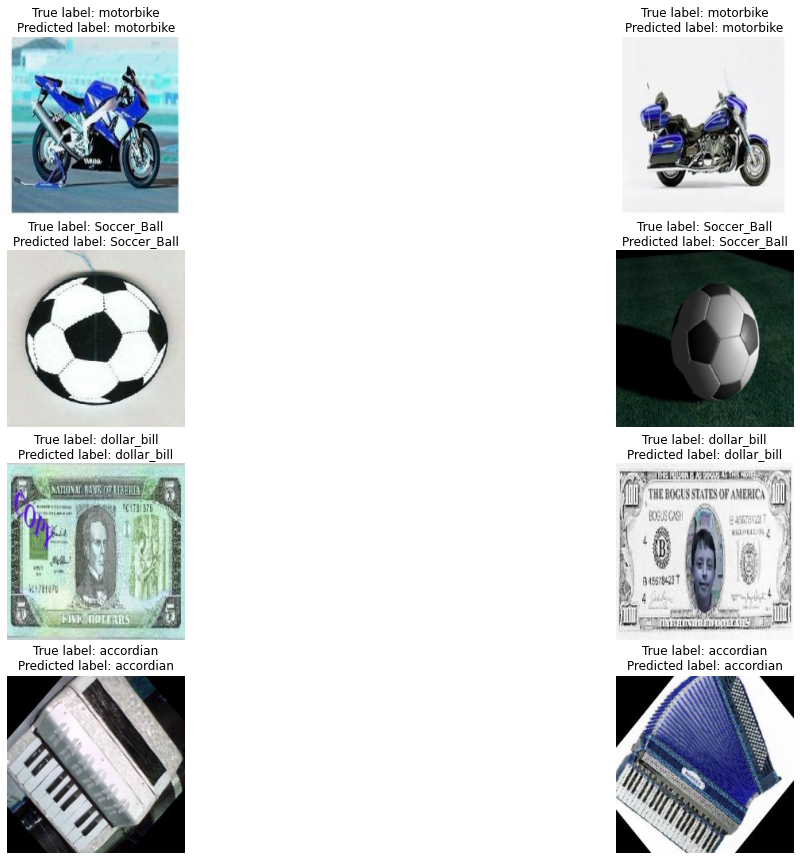

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
images = test_data[:8]
true_labels = test_labels[:8]
predicted_labels = rf_preds[:8]

# Plot images and their predicted and true labels
fig, axs = plt.subplots(4, 2, figsize=(20, 15))
axs = axs.flatten()
for i, (image, true_label, predicted_label) in enumerate(zip(images, true_labels, predicted_labels)):
    axs[i].imshow(image)
    axs[i].set_title(f"True label: {true_label}\nPredicted label: {predicted_label}")
    axs[i].axis('off')

plt.show()


In [19]:
import pickle

# specify file path in Google Drive
filepath = '/content/drive/MyDrive/svm_d1'

# create an iterator object with write permission - model.pkl
with open(filepath, 'wb') as f:
    pickle.dump(svm, f)
# specify file path in Google Drive
filepath = '/content/drive/MyDrive/rf_d1'

# create an iterator object with write permission - model.pkl
with open(filepath, 'wb') as f:
    pickle.dump(rf, f)